# Chapter 13: Variational Quantum Linear Solver

Variational Quantum Linear Solver (VQLS) and parametric circuits.

---

**Note:** This notebook corresponds to Chapter 13 of the textbook.

**Prerequisites:**
- Python 3.8+
- Qiskit 2.1.2
- See `Chapter02_Software.ipynb` for installation instructions


In [9]:
# Setup and imports
import numpy as np
import matplotlib.pyplot as plt
import scipy
# Add utilities to path
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent / 'utilities'))

# Import common utilities
from quantum_utils import simulateCircuit #type: ignore
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.quantum_info import Statevector, Operator
from qiskit.circuit.library import UnitaryGate, QFTGate
from qiskit.circuit.library import QFT, phase_estimation, HamiltonianGate
from qiskit_aer import Aer

print('Setup complete!')

Setup complete!


VQLS Class

In [10]:
from qiskit.quantum_info import SparsePauliOp
class myVQLS:
	# This is an implementation of the VQLS algorithm described in
	# Bravo-Prieto, C.et.al, 2023. 
	# Variational quantum linear solver. Quantum, 7, p.1188.
	def __init__(self, A, b,nShots = 10000):	
		self.A = A
		self.b = b
		self.nShots = nShots
		self.N = self.A.shape[0]
		self.n = int(np.log2(self.N)) # number of qubits to capture b
		self.CostIterations = []
		if (self.n <=4):
			self.ansatzLayers = self.n-1 # for Ansatz
		else:
			self.ansatzLayers = 4 # for Ansatz
		self.dataOK = True
		self.nAnsatzParams = self.n + self.ansatzLayers*(self.n + self.n-2)
		self.ansatzParams = np.random.rand(self.nAnsatzParams)
		if np.abs(2**self.n - self.A.shape[0]) > 1e-10: 
			print("Invalid size of matrix; must be power of 2") 
			self.dataOK = False

		if (not np.isclose(np.linalg.norm(b), 1.0)):
			print('b does not appear to be of unit magnitude')
			self.dataOK = False
		if not (A.shape[0] == b.shape[0]):
			print('A and b sizes are not compatible')
			self.dataOK = False
			
		self.debug = False
		self.computeUbMatrix()
		self.PauliExpansion()
		
	def solveuExact(self):
		# used for verification and not part of HHL
		xExact = scipy.linalg.solve(self.A, self.b)
		self.uExact = xExact/np.linalg.norm(xExact)
		
	def simulateCircuit(self,circuit,nShots=1000):
		backend = Aer.get_backend('qasm_simulator')
		new_circuit = transpile(circuit, backend)
		job = backend.run(new_circuit,shots = nShots)
		counts = job.result().get_counts(circuit)
		return counts

	def computeUbMatrix(self):
		nQubits = self.n
		u =  QuantumRegister(nQubits, 'u')
		circuit = QuantumCircuit(u)
		circuit.prepare_state(Statevector(self.b) ,u)
		self.UbMatrix = Operator(circuit).data
		
	def PauliExpansion(self):
		pauliSplit = SparsePauliOp.from_operator(self.A)
		self.PauliMatrices = []
		for pauliOp in pauliSplit.paulis:
			PauliMatrix = pauliOp.to_matrix()
			self.PauliMatrices.append(PauliMatrix)	
		self.PauliCoefficients = pauliSplit.coeffs
		self.nPauliTerms = len(self.PauliCoefficients)
		return

	def createAnsatzCircuit(self,addMeasurement = False):
		#  implements Fig 3 of reference paper above
		nQubits = self.n
		u =  QuantumRegister(nQubits, 'u')
		if (addMeasurement):
			c = ClassicalRegister(nQubits,'c')
			circuit = QuantumCircuit(u,c)
		else:
			circuit = QuantumCircuit(u)
		ansatzCounter = 0
		for i in range(nQubits):
			circuit.ry(self.ansatzParams[ansatzCounter], u[i])
			ansatzCounter = ansatzCounter+1 
		circuit.barrier()
		for layer in range(self.ansatzLayers):
			for i in range(0,nQubits-1,2):
				circuit.cz(u[i], u[i+1])
			for i in range(nQubits):
				circuit.ry(self.ansatzParams[ansatzCounter], u[i])
				ansatzCounter = ansatzCounter+1 
			for i in range(1,nQubits-1,2):
				circuit.cz(u[i], u[i+1])
			for i in range(1,nQubits-1,1):
				circuit.ry(self.ansatzParams[ansatzCounter], u[i])
				ansatzCounter = ansatzCounter+1 	
			circuit.barrier()
		
		if (addMeasurement):
			circuit.measure(u, c)
		return circuit

	def HadamardTestCircuit1(self,UthetaMatrix, PjMatrix,UbMatrix,imagComponent = False):
		nQubits = self.n
		a = QuantumRegister(1, 'a')
		u =  QuantumRegister(nQubits, '0')
		c = ClassicalRegister(1,'c')
		circuit = QuantumCircuit(a,u,c)
		circuit.h(0)
		if (imagComponent):
			circuit.sdg(0)

		U = UnitaryGate(np.matmul(np.matmul(UbMatrix.conj().T,PjMatrix),UthetaMatrix))
		U._name = r'$ U_{\theta}$'
		UControl = U.control(1)
		circuit.append(UControl,[*range(self.n+1)])

		circuit.h(0)
		circuit.measure([0], [0])
		return circuit


	def HadamardTestCircuit2(self,UthetaMatrix, PjMatrix,PkMatrix,imagComponent = False):
		nQubits = self.n
		u =  QuantumRegister(nQubits, '0')
		a = QuantumRegister(1, 'a')
		c = ClassicalRegister(1,'c')
		circuit = QuantumCircuit(a,u,c)
		circuit.h(0)
		UTheta = UnitaryGate(UthetaMatrix)
		UTheta._name = r'$ U_{\theta}$'
		circuit.append(UTheta, [*range(1,self.n+1)])
		if (imagComponent):
			circuit.sdg(0)
		
		UPj = UnitaryGate(PjMatrix).adjoint()
		UPj._name = r'$ U_{P_j}^{\dag}$'
		UPjControl = UPj.control(1)
		circuit.append(UPjControl, [*range(self.n+1)])
		UPk = UnitaryGate(PkMatrix)
		UPk._name = r'$ U_{P_k}$'
		UPkControl = UPk.control(1)
		circuit.append(UPkControl, [*range(self.n+1)])
		circuit.h(0)
		circuit.measure([0], [0])
		return circuit
		
	def costFunctionExact(self,thetaParams):
		self.ansatzParams = thetaParams.copy()
		self.ansatzCircuit = self.createAnsatzCircuit()
		UTheta = Operator(self.ansatzCircuit).data
		zeroQubit = np.zeros(2**self.n)
		zeroQubit[0] = 1
		u = np.matmul(UTheta,zeroQubit)
		phi =  np.matmul(self.A,u)
		numerator = (np.matmul(self.b,phi))**2
		denominator = np.matmul(phi,phi)
		CG  = 1 - np.real(numerator/denominator)
		self.CostIterations.append(CG)
		return CG
	
	def costFunction(self,thetaParams):
		gReal = np.zeros(self.nPauliTerms)
		gImag = np.zeros(self.nPauliTerms)
		self.ansatzParams = thetaParams.copy()
		self.ansatzCircuit = self.createAnsatzCircuit()
		self.ansatzMatrix = Operator(self.ansatzCircuit).data
		for j in range(self.nPauliTerms):
			circ1Real = self.HadamardTestCircuit1(self.ansatzMatrix,
										   self.PauliMatrices[j],self.UbMatrix)
			counts = self.simulateCircuit(circ1Real,self.nShots)
			gReal[j] = (counts.get('0', 0)- counts.get('1', 0))/self.nShots
			circ1Imag = self.HadamardTestCircuit1(self.ansatzMatrix,
										   self.PauliMatrices[j],self.UbMatrix,True)
			counts = self.simulateCircuit(circ1Imag,self.nShots)
			gImag[j] = (counts.get('0', 0)- counts.get('1', 0))/self.nShots
		
		numerator = 0
		for j in range(self.nPauliTerms):
			aj = self.PauliCoefficients[j]
			numerator = numerator + aj*(gReal[j]+1j*gImag[j])
		
		numerator = (numerator)**2
		hReal = np.zeros((self.nPauliTerms,self.nPauliTerms))
		hImag =  np.zeros((self.nPauliTerms,self.nPauliTerms))
		for j in range(self.nPauliTerms):
			for k in range(self.nPauliTerms):
				circ2Real = self.HadamardTestCircuit2(self.ansatzMatrix, self.PauliMatrices[j],self.PauliMatrices[k])
				counts = self.simulateCircuit(circ2Real,self.nShots)
				hReal[j][k] = (counts.get('0', 0)- counts.get('1', 0))/self.nShots
				
				circ2Imag = self.HadamardTestCircuit2(self.ansatzMatrix, self.PauliMatrices[j],self.PauliMatrices[k],True)
				counts =  self.simulateCircuit(circ2Imag,self.nShots)
				hImag[j][k] = (counts.get('0', 0)- counts.get('1', 0))/self.nShots
				
		denominator = 0
		for j in range(self.nPauliTerms):
			aj = self.PauliCoefficients[j]
			for k in range(self.nPauliTerms):
				ak = self.PauliCoefficients[k]
				denominator = denominator + aj*ak*(hReal[j][k]+1j*hImag[j][k])

		CG  = 1 - np.real(numerator/denominator)
		self.CostIterations.append(CG)
		return CG
	
	def plotCostFunction(self,nSamples = 33):
		if (self.n > 1):
			print('plotCostFunction is only valid for 1 qubit')
			return False
		if not self.dataOK:
			print('Check input data')
			return False
		thetaParams = np.zeros(self.nAnsatzParams)
		thetaValues = np.linspace(0,2*np.pi,nSamples)
		CGValues = []
		for theta in thetaValues:
			thetaParams[0] = theta
			CG = np.real(self.costFunction(thetaParams))
			CGValues.append(CG)
		plt.plot(thetaValues,CGValues)
		plt.xlabel(r'$\theta$')
		plt.ylabel(r'$C_G$')
		plt.grid(True)
	def executeVQLS(self):
		if not self.dataOK:
			print('Check input data')
			return False

		self.CostIterations = []
		thetaParams = np.random.rand(self.nAnsatzParams)
		result = scipy.optimize.minimize(self.costFunction,
								   thetaParams, method='COBYLA' )
		
		self.minCG = result['fun']
		self.thetaOptimal = result['x']
		self.ansatzParams = self.thetaOptimal.copy()
		self.ansatzCircuit = self.createAnsatzCircuit(True)
		counts = self.simulateCircuit(self.ansatzCircuit,self.nShots)
		self.uVQLS = 0
		for key in counts:
			v = np.real(Statevector.from_label(key)) # extract v 
			self.uVQLS = self.uVQLS + v*np.sqrt(counts[key]/self.nShots)


## VQLS Examples

In [11]:
from scipy.sparse import diags

example = 1
if (example == 1):
	A = np.array([[1,0],[0,0.75]]) 
	b = np.array([0,1])
elif (example == 2):
	A = np.array([[2,-1],[-1,2]])
	b = np.array([1,1])/np.sqrt(2)
elif (example == 3):
	A = np.array([[1,0,0,-0.5],[0,1,0,0],[0,0,1,0],[-0.5,0,0,1]])
	b = np.array([1,0,0,0])
elif (example == 4):
	A = np.array([[1.5,0.5],[0.5,1.5]])
	b = np.array([1,0])
elif (example == 5):
	p = 2
	A = np.array([[5*(10**p),-1],[-1,5]])
	b = np.array([1,0])
elif (example == 6):
	N = 4
	values = [-np.ones(N-1),2*np.ones(N),-np.ones(N-1)]
	A = diags(values,[-1,0,1]).toarray()
	b = np.zeros(N)
	b[0] = 1

print("A:\n", A)
print("b:\n", b)

A:
 [[1.   0.  ]
 [0.   0.75]]
b:
 [0 1]


## VQLS Execution

Exact sol: [0. 1.]
------------------------------
Min Cost:  0.0014135348039308049
Optimal theta:  [2.98820731]
VQLS  sol: [0.05477226 0.99849887]


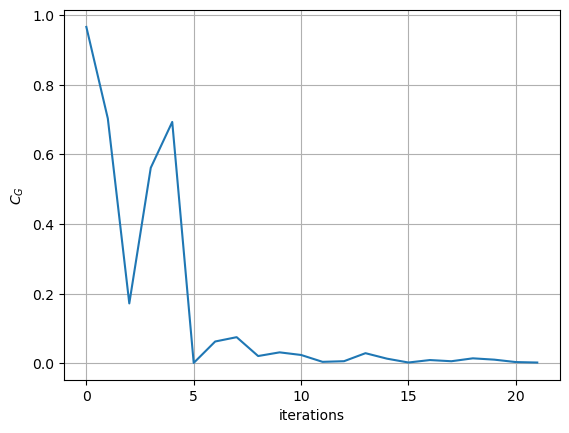

In [12]:
nShots = 1000
vqls = myVQLS(A, b,nShots)

vqls.solveuExact()
print('Exact sol:',vqls.uExact)
vqls.executeVQLS()
plt.plot(vqls.CostIterations)
plt.xlabel(r'iterations')
plt.ylabel(r'$C_G$')
plt.grid(True)
print("------------------------------")
print('Min Cost: ', vqls.minCG)
print('Optimal theta: ', vqls.thetaOptimal)
print('VQLS  sol:',vqls.uVQLS)